<a href="https://colab.research.google.com/github/JakobRobnik/MicroCanonicalHMC/blob/master/tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **MCHMC tutorial - sampling from a Standard Gaussian target distribution**

First, let's import the MCHMC code.

In [ ]:
!git clone https://github.com/JakobRobnik/MicroCanonicalHMC.git

We will be using jax, as it can automatically compute gradients.

In [2]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt

from MicroCanonicalHMC import ESH

In this example we will sample from a standard Gaussian target. Let's define the negative log density:

In [3]:
nlogp = lambda x: 0.5*jnp.sum(jnp.square(x))

and get the gradient with jax:

In [4]:
grad_nlogp = jax.grad(nlogp)


The target is a class with functions nlogp, grad_nlogp and transform. Some common targets are implemented in `targets.py`.
Let's here define the standard Gaussian target:

In [18]:
class StandardGaussian():
  
  def __init__(self, d):
    self.d = d
  
  def nlogp(self, x):
     return nlogp(x)

  def grad_nlogp(self, x):
     return grad_nlogp(x)

  def transform(self, x):
    return jnp.array([x[0], jnp.sum(jnp.square(x))])

When the dimensionality is high, storing all of the samples may become memory intesive. However, we are ususally only iterested in some lower dimensional marginal distribution. `transform` is used in those cases as a map to the lower dimensional space of interest. As an illustration we will here only store $x_1$ and $\sum_{i=1}^d x_i^2$.

Let's sample from a $d = 100$ dimensional target. We will set the step-size of the Hamiltonian dynamics integrator to unity. The momentum decoherence speed parameter L is set to it's default value $\sqrt{d}$.

In [19]:
d= 100
sampler = ESH.Sampler(StandardGaussian(d), eps = 1.0)
L = jnp.sqrt(d)

We will use gradual momentum decoherence mechanism (`generalized= True`) and take $10^5$ samples.

In [23]:
key = jax.random.PRNGKey(0) #random seed
x0 = jnp.ones(d) #initial condition
samples, weights = sampler.sample(x0, 100000, L, key, generalized= True)

The sampler returns the samples and the associated weights.

In [24]:
print(jnp.shape(samples))
print(jnp.shape(weights))

(100000, 2)
(100000,)


Let's plot the one dimensional marginal distribution along the $x_1$ coordinate.

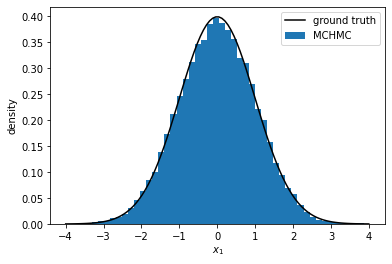

In [25]:
plt.hist(samples[:, 0], bins = 50, weights = weights, density = True, label = 'MCHMC')

from scipy.stats import norm

t = jnp.linspace(-4, 4, 100)
plt.plot(t, norm.pdf(t), color = 'black', label = 'ground truth')

plt.xlabel(r'$x_1$')
plt.ylabel('density')
plt.legend()
plt.show()